# Atelier pour le cours d'astronomie

## Contexte

Dans cet atelier, nous allons explorer l'analyse de données du télescope spatial James Webb (JWST).
Nous allons calculer la photométrie de naines Y en utilisant les données du programme [GO 2473](https://www.stsci.edu/jwst-program-info/program/?program=2473), mené par mon collègue [Loïc Albert](https://exoplanetes.umontreal.ca/en/team-member/loic-albert/).

Les naines Y sont les [naines brunes](https://fr.wikipedia.org/wiki/Naine_brune) les plus froides et les moins brillantes.
Les naines brunes sont des objets astrophysiques qui se forment comme les étoiles, mais qui n'atteignent pas une masse suffisamment élevée pour la fusion nucléaire.
Ainsi, elles se refroidissent continuellement avec le temps et ont des masses entre 13 et 75 fois celle de Jupiter.
Leur faible masse et leur basse température font qu'elles ressemblent en plusieurs points aux exoplanètes géantes.
Or, elles sont souvent isolées (elles n'orbitent pas une étoile), ce qui les rend plus faciles à observer.
Elles sont donc, en plus d'être intéressantes en elles-même, d'excellent « proxy » pour mieux comprendre les planètes géantes.

Vu leur basse température, les naines Y émettent la majorité de leur lumière dans l'infrarouge.
Ceci les rend très difficile à observer à partir du sol, ou bien à partir de l'espace avec un télescope opérant dans le visible comme Hubble.
Le télescope Webb est donc l'observatoire parfait pour les étudier plus en détails.
Plus spécifiquement, nous avons obtenu des données d'imagerie avec l'instrument [NIRCam](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-observing-modes/nircam-imaging#gsc.tab=0).

L'objectif principal de ce programme d'observation est la recherche de compagnons.
Par compagnon, on désigne d'autres naines Y encore plus froides qui seraient en orbite autour des cibles de notres programmes.
Elles ne sont techniquement pas des planètes car les naines brunes ne sont pas des étoiles.
Nous avons pour l'instant trouvé [un seul compagnon](https://ui.adsabs.harvard.edu/abs/2023ApJ...947L..30C/abstract), et je suis en train de compléter l'analyse du programme dans un article qui devrait paraître plus tard cette année.

Vu la qualité des données Webb, il est également intéressant de contraindre la luminosité des cibles dans le programme via une analyse photométrique.
Mon collègue Loïc a récemment publié [un article](https://ui.adsabs.harvard.edu/abs/2025AJ....169..163A/abstract) à ce sujet.
Aujourd'hui, nous allons reproduire certaines parties de cette analyse.
Plus spécifiquement, nous allons:

- Accéder aux données en ligne via Python
- Visualiser les données
- Calculer la somme du flux dans les images pour calculer la photométrie

## Importation et visualisation d'une image

### Accès aux données via MAST

Les données JWST sont disponibles sur le portail [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html).
Ce portail en ligne peut-être utilisé manuellement ou bien avec Python.
Pour l'utiliser avec Python, nous allons recourir à [astroquery](https://astroquery.readthedocs.io/en/latest/).
Si on connait l'URL des données qu'on souhaite télécharger, l'interface est assez simple.

Les observations ont été effectuées avec deux filtres photométriques (couleurs): F150W et F480M.
Le premier est un filtrer large (W pour _wide_) observant à 1.5 $\mu$m et le second est un filtre moyen (M pour _medium_) observant à 4.8 $\mu$m.
Observer avec deux filtres différents nous permet de calculer la couleur de l'objet pour la comparer avec des modèles théoriques, et NIRCam peut observer deux couleurs en parallèle, donc aucun temps additionnel n'est requis!

Ici, j'ai pré-sélectionné les observations de WISE-0366, l'une des cibles observée par notre programme.
Le code ci-dessous télécharge ces données si elles ne sont pas déjà sur votre ordinateur.

In [1]:
from pathlib import Path
from astroquery.mast import Observations

# Les objets "Path" sont plus pratique à manipuler que des strings
data_dir = Path("./data")

# Dictionnaire donnant le nom des fichiers pour chaque filtre (couleur).
files = {
    "f150w": "jw02473-o053_t053_nircam_clear-f150w_i2d.fits",
    "f480m": "jw02473-o053_t053_nircam_clear-f480m_i2d.fits",
}
base_uri = "mast:JWST/product/"
for file in files.values():
    file_path = data_dir / file
    if not file_path.exists():
        file_uri = base_uri + file
        print(f"Downloading file from {file_uri} to {file_path}")
        Observations.download_file(file_uri, local_path=file_path)

Voilà! Les données devraient maintenant apparaître sous `data`:

In [2]:
print(f"Données dans {data_dir}:")
list(data_dir.iterdir())  # Alternative à os.listdir()

Données dans data:


[PosixPath('data/jwst_nircam_abvegaoffset_0002.asdf'),
 PosixPath('data/jwst_nircam_apcorr_0004.fits'),
 PosixPath('data/UID_0113357_RVC_001.tbl'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/jw02473-o053_t053_nircam_clear-f150w_i2d.fits'),
 PosixPath('data/jw02473-o053_t053_nircam_clear-f480m_i2d.fits')]

### Ouverture des fichiers et méta-données

Maintenant que les fichiers sont sur notre disque dur, on peut utiliser [Astropy](https://docs.astropy.org/en/latest/io/fits/index.html) pour les ouvrir.
Commençons par explorer le contenu du fichier en F480M.

In [3]:
filename = files["f480m"]
filepath = data_dir / filename

In [4]:
from astropy.io import fits

hdul = fits.open(filepath)
print("Informations du fichier F480M:")
hdul.info()

Informations du fichier F480M:
Filename: data/jw02473-o053_t053_nircam_clear-f480m_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  SCI           1 ImageHDU        75   (2076, 2070)   float32   
  2  ERR           1 ImageHDU        10   (2076, 2070)   float32   
  3  CON           1 ImageHDU        10   (2076, 2070, 1)   int32   
  4  WHT           1 ImageHDU         9   (2076, 2070)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2076, 2070)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2076, 2070)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2076, 2070)   float32   
  8  HDRTAB        1 BinTableHDU    844   5R x 417C   [23A, 5A, 3A, 48A, 7A, 13A, 6A, 5A, 6A, 7A, 10A, 4A, L, D, D, D, D, 32A, 50A, 74A, 12A, 2A, D, 33A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 9A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 12A, 14A, 5A, D, D, D, D, D, D, 27A, D, D, D, 6A, 8

Comme on peut voir ici, le fichier contient plusieurs extensions.
Chaque extension peut inclure une en-tête avec des méta-données, ainsi que des données (image, tableau, etc.).
Par convention, l'extension 0 (`PRIMARY`) ne contient pas de données et seulement une en-tête avec des informations sur le programme.
Les observations qui nous intéressent sont dans l'extension `1`, ou `"SCI"`.

In [5]:
import pprint  # pretty print

hdr = hdul[0].header
sci_hdr = hdul["SCI"].header
data_f480m = hdul["SCI"].data
hdul.close()  # On ferme le fichier maintenant que tout est extrait
print("En-tête:")
pprint.pprint(hdr)

En-tête:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2025-01-02T00:50:43.903' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw02473-o053_t053_nircam_clear-f480m_i2d.fits' / Name of the file    
SDP_VER = '2024_3a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-068'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '8.4.14  '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC31   

In [6]:
print("En-tête SCI:")
pprint.pprint(sci_hdr)

En-tête SCI:
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2076                                                  
NAXIS2  =                 2070                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =   59844.534540144676 / [d] exposure start time in MJD                 
MJD-AVG =   59844.550819277196 / [d] exposure mid-point in MJD                  
MJD-END =     59844.5670987037 / [d] exposure end time in MJD                   
TDB-BEG =    59844.53867070307 / [d] TDB time of exposure start in MJD          
TDB-MID =    59

Voilà pour les en-têtes. On peut en extraire de l'information utile, notamment les unités dans lesquelles le flux est rapporté.

In [7]:
flux_units = sci_hdr["BUNIT"]
print("Unités du flux:")
print(flux_units)

Unités du flux:
MJy/sr


Les données sont en megaJansky par steradian (Luminiso).
Un Jansky mesure la densité de flux spectrale et est égal à $10^{−26}$ W m$^{−2}$ Hz$^{−1}$.

### Affichage de l'image

Regardons maintenant de quoi a l'air notre image.

In [8]:
print("Type de donnée:", type(data_f480m))
print("Format des données:", data_f480m.shape)
print("Données:")
print(data_f480m)

Type de donnée: <class 'numpy.ndarray'>
Format des données: (2070, 2076)
Données:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Les images sont stockées en tableaux [NumPy](https://numpy.org/).
On voit ici que l'image a une taille de 2070x2076 pixels.
Par contre, lorsqu'on imprime les données, tous les pixels ont une valeur `nan`, pour « not a number ».
Cette valeur est utilisée pour signifier que les pixels au bord de l'image sont inutilisables.
Si on regarde un segment au centre de l'image, on devrait voir des valeurs numériques.
Une façon rapide de le vérifier est d'afficher l'image avec Matplotlib.

La fonction `plt.imshow()` nous permet d'afficher l'image.
On peut ajouter une barre de couleurs avec `plt.colorbar()` pour avoir une idée des valeurs numériques.

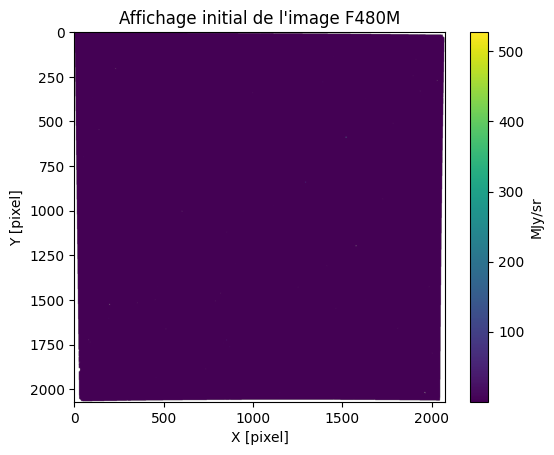

In [9]:
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")

plt.imshow(data_f480m)
plt.title("Affichage initial de l'image F480M")
plt.xlabel("X [pixel]")
plt.ylabel("Y [pixel]")
plt.colorbar(label=flux_units)
plt.show()

On voit que la majorité des pixels ne sont en effet pas des `nan`. Bonne nouvelle!
Par contre, on ne voit pas grand chose dans l'image
Ceci se produit généralement lorsque quelques pixels sont très brillants. Le reste des pixels apparaît alors comme très sombres.
On pourrait manuellement zoomer sur la barre de couleurs, mais ce n'est pas optimal.

Voyons voir si une échelle logarithmique nous aide à y voir plus clair avec `norm="log"`.
N'hésitez pas à zoomer sur l'image pour voir la forme des sources de lumière.

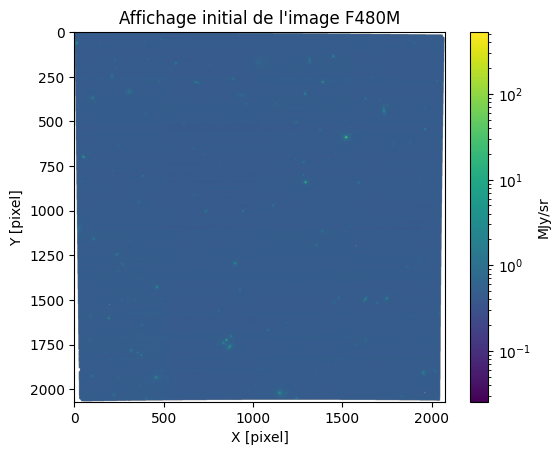

In [10]:
plt.imshow(data_f480m, norm="log")
plt.title("Affichage initial de l'image F480M")
plt.xlabel("X [pixel]")
plt.ylabel("Y [pixel]")
plt.colorbar(label=flux_units)
plt.show()

On voit dans l'image ci-dessus que nos images NIRCam sont des images à grand champ: on n'observe pas uniquement l'étoile ou la naine brune qui nous intéresse, mais son voisinage également.
Nous identifierons WISE-0336 plus bas

Il resterait deux choses à faire pour améliorer la visualisation:

1. Matplotlib mets le pixel `(0, 0)` en haut à gauche de l'image, comme il est positionné dans un tableau. Il est plus intuitif de l'afficher en bas avec `origin="lower"`. On peut ajouter cet argument à `plt.imshow()` ou configurer Matplotlib pour le reste du code avec `rcParams`.
2. Les sources les plus brillantes affectent encore l'échelle de la barre de couleurs. Les arguments `vmin` et `vmax` permettent de changer la gamme dynamique de l'image. On peut utiliser les quantiles de l'image pour les ajuster.
3. On peut changer [les couleurs](https://matplotlib.org/stable/users/explain/colors/colormaps.html) pour du rouge, afin de mieux représenter l'infrarouge (totalement facultatif, on pourrait utiliser une échelle de gris également).


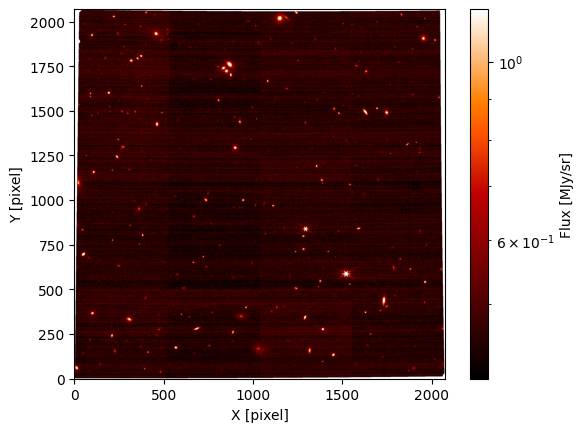

In [11]:
import numpy as np
from matplotlib import rcParams

# rcParams nous permet de configurer matplotlib
rcParams["image.origin"] = "lower"  # Mettre l'origine en bas à gauche avec imshow
rcParams["image.cmap"] = "gist_heat"  # Mettre l'origine en bas à gauche avec imshow

# On peut ignorer le premier percentile et le dernier 0.1% pour l'échelle de couleurs
vmin = np.nanquantile(data_f480m, 0.03)  # nanqantile est une version de quantile robuste aux nan
vmax = np.nanquantile(data_f480m, 0.999)

plt.imshow(data_f480m, norm="log", vmin=vmin, vmax=vmax)
plt.xlabel("X [pixel]")
plt.ylabel("Y [pixel]")
plt.colorbar(label=f"Flux [{flux_units}]")
plt.show()

On voit certains effets de détecteur dans les images: des lignes horizontales et 4 rectangles verticaux.
On peut les ignorer pour l'instant. On se concentrera sur une toute petite région du détecteur.

## Images dans les deux couleurs

Maintenant que la structure des images nous est familière, on peut importer les donné du filtre F150W également.
La structure est la même que pour les données F480M.
On peut créer un dictionnaire pour y accéder facilement.


In [12]:
with fits.open(data_dir / files["f150w"]) as hdul_f150w:
    data_f150w = hdul_f150w["SCI"].data

data_dict = {
    "f480m": data_f480m,
    "f150w": data_f150w,
}

On peut maintenant afficher les images.
Nous répéterons ces opérations quelque fois, donc on peut créer des fonctions.

In [13]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure

# Les "type hint" donnent le type de la variable.
# Ils sont à titre informatif seulement
def plot_image(
    img: np.ndarray,
    ax: Axes | None = None,
    fig: Figure | None = None,
    **kwargs,
) -> tuple[Figure, Axes]:
    """
    Fonction pour afficher une image en nommant les axes et avec une barre de couleurs.
    Tous les autres arguments (kwargs) sont passés à imshow.

    :param img: Image
    :param ax: Axe sur lequel on affiche, None par défaut (plt.gca())
    :param fig: Figure sur laquelle on affiche, None par défaut (plt.gcf())
    :return: Retourne la figure et les axes
    """
    ax = ax or plt.gca()
    fig = fig or plt.gcf()
    im = ax.imshow(img, norm="log", **kwargs)
    ax.set_xlabel("X [pixel]")
    ax.set_ylabel("Y [pixel]")
    fig.colorbar(im, label=f"Flux [{flux_units}]", ax=ax)
    return fig, ax

def plot_images(
    data_dict: dict[str, np.ndarray],
    pos_dict: dict[str, tuple[int, int]] | None = None,
    use_vmin_vmax: bool = False,
) -> tuple[Figure, Axes]:
    """
    :param data_dict: dictionnaire du nom des filtre vers les les images
    :param data_dict: dictionaire du nom des filtres vers la position des sources. Optionnel
    """
    data_f480m = data_dict["f480m"]
    data_f150w = data_dict["f150w"]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    if use_vmin_vmax:
        vmin = np.nanquantile(data_f480m, 0.03)
        vmax = np.nanquantile(data_f480m, 0.999)
    else:
        vmin = vmax = None
    plot_image(data_f480m, ax=axs[0], fig=fig, vmin=vmin, vmax=vmax)
    axs[0].set_title("F480M")

    if use_vmin_vmax:
        vmin = np.nanquantile(data_f150w, 0.03)
        vmax = np.nanquantile(data_f150w, 0.999)
    plot_image(data_f150w, ax=axs[1], fig=fig, vmin=vmin, vmax=vmax)
    axs[1].set_title("F150W")

    if pos_dict is not None:
        axs[0].plot(*pos_dict["f480m"], "C0*")
        axs[1].plot(*pos_dict["f150w"], "C0*")

    return fig, axs

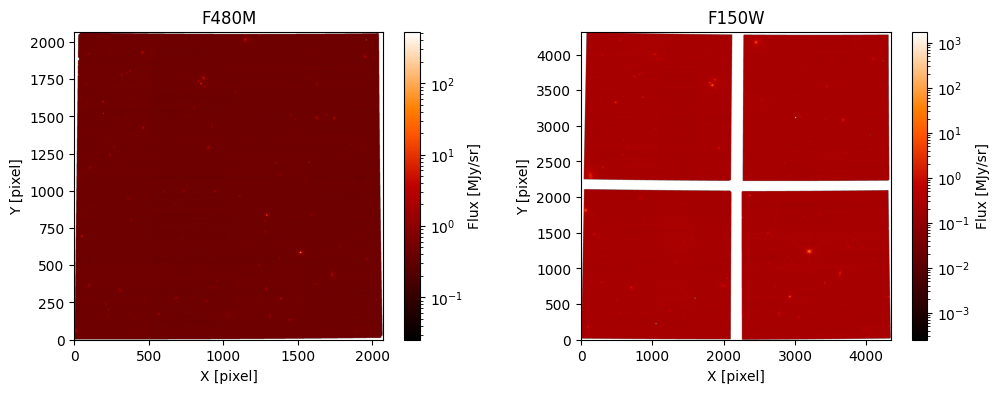

In [14]:
plot_images(data_dict)
plt.show()

On remarque que le détecteur « bleu » ou _Courtes longueurs d'ondes_ de NIRCam est segmenté en 4.
Voir la [documentation](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-detector-overview#gsc.tab=0) pour plus de détails.

Ajustons l'échelle pour mieux voir les sources

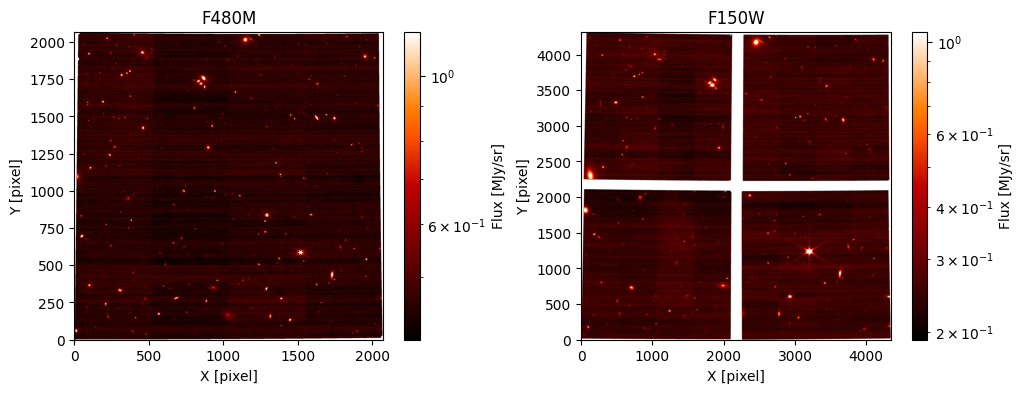

In [15]:
plot_images(data_dict, use_vmin_vmax=True)
plt.show()

## Position de la source

On pourrait ancrer l'image à des coordonnées [WCS](https://docs.astropy.org/en/stable/wcs/index.html), mais ce ne sera pas nécessaire pour notre exercice.
Les images ont été obtenues à grand champ, mais on la photométrie se calcule uniquement dans les quelques pixels autour de notre source d'intérêt.

WISE-0336 est une naine Y, donc elle est très froide, ce qui veut dire qu'elle est beaucoup plus brillante en F480M qu'en F150W.
Essayons de l'identifier visuellement d'abord.

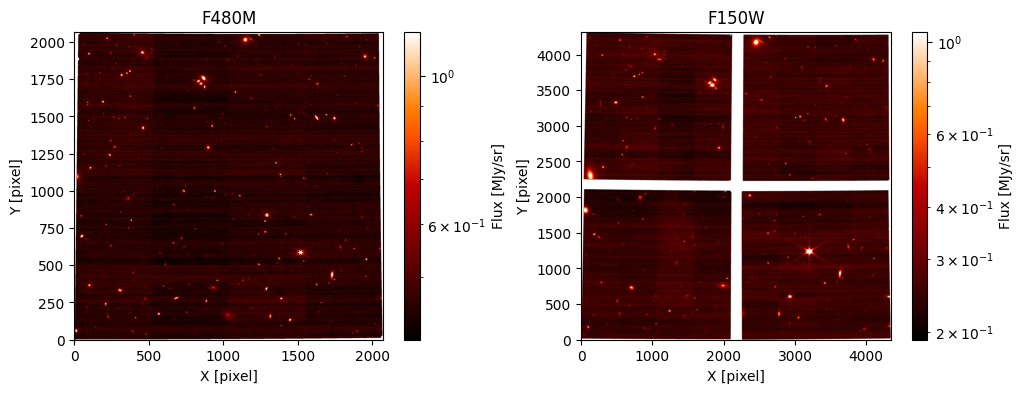

In [16]:
plot_images(data_dict, use_vmin_vmax=True)
plt.show()

Pour notre projet, nous avons d'abord cherché les sources de cette manière, puis nous avons confirmé la position avec les coordonnées connues.
La position pour chaque filtre est notée ci-dessous.

In [17]:
object_name = "WISE-0336"
f150_pos = (2734, 1759)
f480_pos = (1296, 840)
pos_dict = {
    "f480m": f480_pos,
    "f150w": f150_pos,
}

On peut afficher la position pour chaque filtre ensuite.


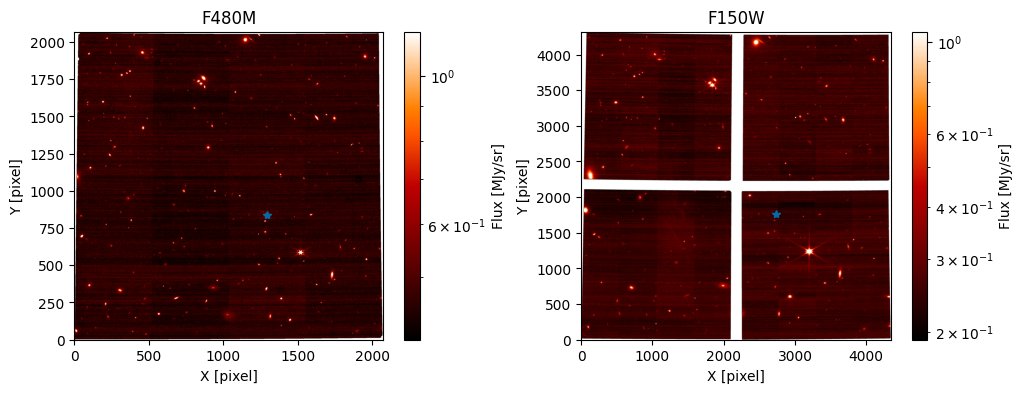

In [18]:
plot_images(data_dict, use_vmin_vmax=True, pos_dict=pos_dict)
plt.show()

## Découpage de la source

Maintenant que nous avons trouvé WISE-0336, inutile de garder toute l'image.
Une région d'une soixantaine de pixels suffira.
Dans chaque filtre, on peut découper 68 pixels autour de la source et afficher cette nouvelle image.

In [19]:
crop_half_size = 34

crop_dict = dict()
for filt in data_dict:
    data = data_dict[filt]
    pos = pos_dict[filt]
    x, y = pos
    data_crop = data[y-crop_half_size:y+crop_half_size,x-crop_half_size:x+crop_half_size]
    crop_dict[filt] = data_crop

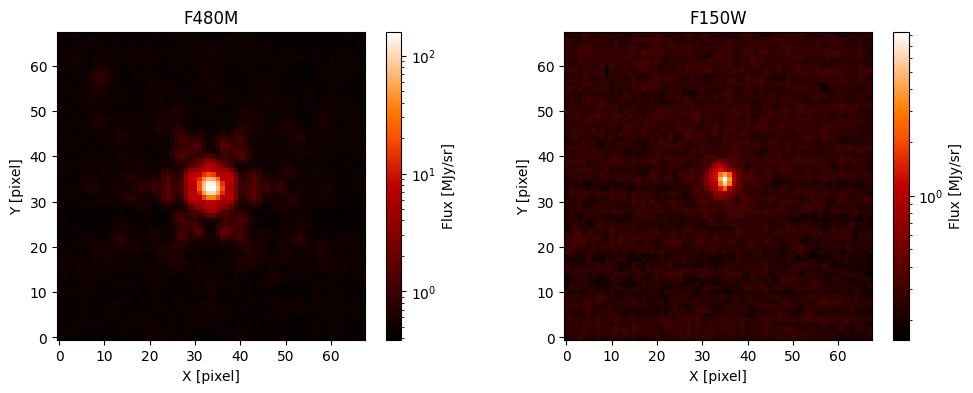

In [20]:
fig, axs = plot_images(crop_dict)
plt.show()

## Photométrie d'ouverture

Maintenant que la cible d'intérêt est isolée, on peut calculer sa luminosité.
Comme dans l'article mentionné au début du code, nous utiliserons la photométrie d'ouverture.
Cette technique consiste à:

1. Trouver le centre de la cible
2. Définir une ouverture circulaire d'une taille donnée autour du centre
3. Calculer le flux total dans l'ouverture
4. Définir un anneau autour de la cible pour calculer le bruit de fond
5. Soustraire le bruit de fond
6. Convertir le flux en magnitude

La librairie [photutils](https://photutils.readthedocs.io/en/stable/) implémente ce dont nous avons besoin pour faire ces calculs (sauf 6).
Cependant, afin de bien comprendre toutes les étapes, c'est toujours une bonne idée de coder la solution manuellement lorsque l'on s'intéresse à un problème pour une première fois.
Nous allons donc tout calculer nous même et comparer nos résultats avec ceux de photutils.
Nous utiliserons uniquement les données F480M, comme le signal est meilleur dans ce filtre.

**Note: Nous avons coupé les données à une taille égale de chaque côté. Ceci permet à des erreurs de dimensions de se glisser très facilement dans nos calcul. Un truc simple pour éviter ces erreurs pendant le développement est de changer la taille d'un des axes avec `data= data[:-1]`**.
On peut ensuite enlever cette opération quand le code est terminé.

In [21]:
# TODO: Remove :-1
data = crop_dict["f480m"]
data = data[:-1]

### Conversion des unités

Avant de commencer nos calculs il faut convertir les unités de flux.
Comme mentionné plus tôt, les données sont en MJy/sr, qui donne une luminosité de surface.
Ici, on souhaite travailler directement avec un flux. Nous avons deux options:

1. Convertir les données vers des photons/seconde avec `sci_hdr["PHOTMJSR"]`
2. Convertir les données vers des Jansky avec `sci_hdr["PIXAR_SR"]`, qui donne la surface d'un pixel en steradian

Le calcul de la photométrie se fait de la même façon dans les deux cas.
Seule l'étape 6 est différente.
Ici, nous allons utiliser l'option 2 car elle simplifie légèrement l'étape 6.

In [22]:
# 1e6 Jy/MJy et PIXAR_SR SR / pixel
# TODO: F150W
mjsr_to_jy = 1e6 * sci_hdr["PIXAR_SR"]
data = data * mjsr_to_jy
flux_units = "Jy"

### 1. Trouver le centre de la cible

Commençons par vérifier si la cible est au centre de l'image.

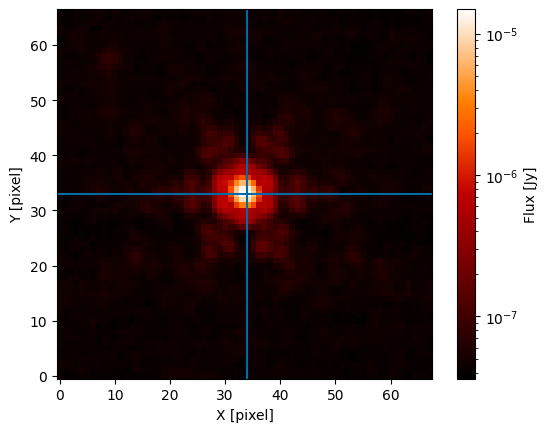

In [23]:
y_half = data.shape[0]//2
x_half = data.shape[1]//2
plot_image(data)
plt.axhline(y_half)
plt.axvline(x_half)
plt.show()

Elle ne semble pas l'être tout à fait! Regardons de plus près.

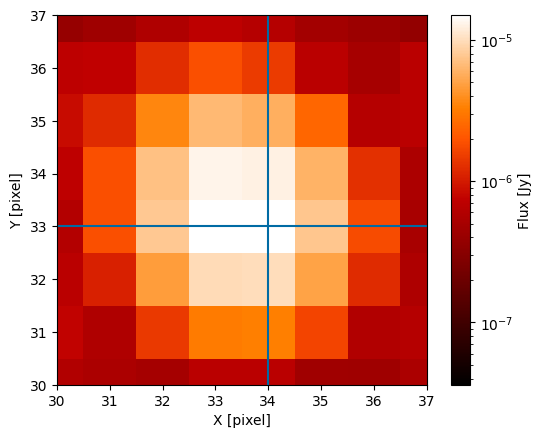

In [24]:
plot_image(data)
plt.axhline(y_half)
plt.axvline(x_half)
plt.xlim(30, 37)
plt.ylim(30, 37)
plt.show()

On remarque deux choses:

1. Le pixel central n'est pas nécessairement le plus brillant.
2. L'image n'est pas parfaitement centrée sur un pixel.

Le point 1 vient du fait que nous avons déterminé la position de la source approximativement avant de découper l'image.
Pour ce qui est du point 2, il se peut que la source soit centrée entre deux pixels. Il faut donc calculer une position centrale plus précise, et pas seulement trouver le pixel le plus brillant.

Il y a différentes façons de trouver le centre d'une image. Photutils implémente celles-ci dans son module [`centroids`](https://photutils.readthedocs.io/en/stable/user_guide/centroids.html):

- Trouver le "centre de masse" de l'image
- Ajuster un polynôme quadratique en 2 dimensions au centre de l'image
- Ajuster une distribution gaussienne 1D à chaque dimension de l'image
- Ajuster une distribution gaussienne 2D à l'image

Nous utiliserons la première méthode ci-dessus: celle du centre de masse (CDM).
Ici, centre de masse est une analogie: le flux dans chaque pixel est la « masse » du pixel.
On doit donc calculer une moyenne pondérée de la position des pixels où les poids sont le flux dans chaque pixel.
Ainsi, si tous les pixels sont égaux, le CDM est au milieu de l'image.
Si tous les pixels sont à 0 mais qu'un pixel est non nul, le CDM sera sur ce pixels.
Si tous les pixels sont à 0 mais que deux pixels sont non nuls et égaux, le CDM sera à mi-chemin entre ces deux pixels.
Dans un cas réaliste comme ici, aucun pixel n'est nul. Chaque pixel "tire" le centre de masse vers lui en fonction de son flux.

Nous allons donc calculer une somme pondérée de la position des pixels.

Position du centre de masse: (x, y) = (np.float32(33.407093), np.float32(33.166183))


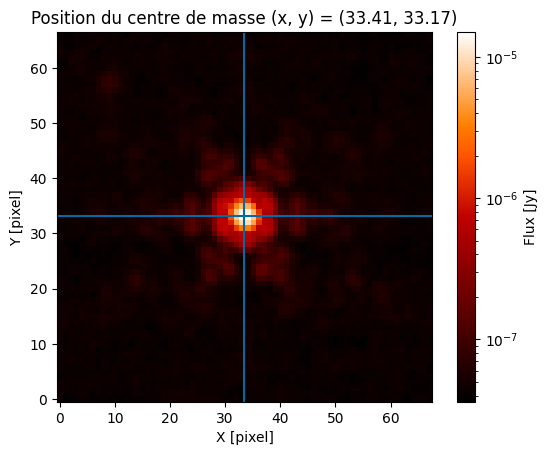

In [25]:
sy, sx = data.shape
mean_x = 0.0
mean_y = 0.0
for y in range(sy):
    for x in range(sx):
        flux = data[y, x]
        mean_x += x * flux
        mean_y += y * flux
total = np.sum(data)
mean_x = mean_x / total
mean_y = mean_y / total

print("Position du centre de masse: (x, y) =", (mean_x, mean_y))

plot_image(data)
plt.axvline(mean_x)
plt.axhline(mean_y)
plt.title(f"Position du centre de masse (x, y) = ({mean_x:.2f}, {mean_y:.2f})")
plt.show()

Voyons maintenant ce que `photutils` trouve comme centre de masse.

In [26]:
from photutils.centroids import centroid_com
xy_com = centroid_com(data)
print("Centre de masse photutils", xy_com)

Centre de masse photutils [33.40710077 33.16618283]


/home/vandal/miniforge3/envs/cegep/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2 et 4. Ouverture circulaire et anneau pour le bruit de fond

In [27]:
src_aperture = {
    "x": [],
    "y": [],
    "flux": [],
}
bkg_aperture = {
    "x": [],
    "y": [],
    "flux": [],
}
r_src = 8
r_in = 10
r_out = 15
for x in range(sx):
    for y in range(sy):
        dx = x - mean_x
        dy = y - mean_y
        r = np.sqrt(dx**2 + dy**2)
        if r < r_src:
            src_aperture["x"].append(x)
            src_aperture["y"].append(y)
            src_aperture["flux"].append(data[y, x])
        if r_in < r < r_out:
            bkg_aperture["x"].append(x)
            bkg_aperture["y"].append(y)
            bkg_aperture["flux"].append(data[y, x])

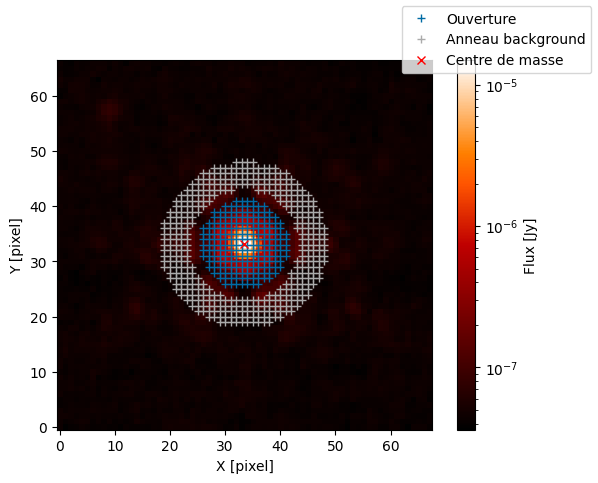

In [28]:
fig, ax = plot_image(data)
plt.plot(src_aperture["x"], src_aperture["y"], "C0+", label="Ouverture")
plt.plot(bkg_aperture["x"], bkg_aperture["y"], "C2+", label="Anneau background")
plt.plot(mean_x, mean_y, "rx", label="Centre de masse")
fig.legend()
plt.show()

Voyons voir ce qu'en dit `photutils`.
Le module [`aperture`](https://photutils.readthedocs.io/en/stable/user_guide/aperture.html) contient ce dont nous avons besoin.

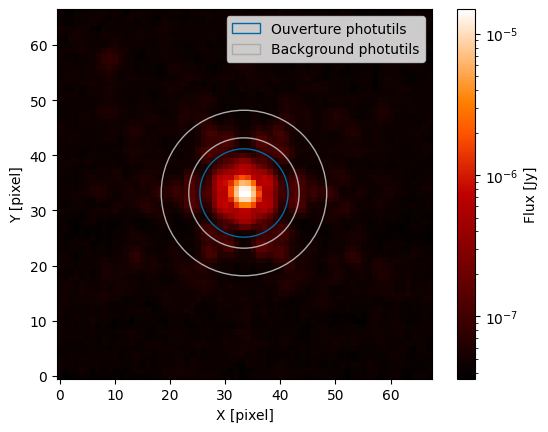

In [29]:
from photutils.aperture import CircularAnnulus, CircularAperture

src_photutils = CircularAperture(xy_com, r=r_src)
bkg_photutils = CircularAnnulus(xy_com , r_in=r_in, r_out=r_out)

fig, ax = plot_image(data)
src_photutils.plot(ax=ax, color="C0", label="Ouverture photutils")
bkg_photutils.plot(ax=ax, color="C2", label="Background photutils")
plt.legend()
plt.show()

Et superposons les deux méthodes

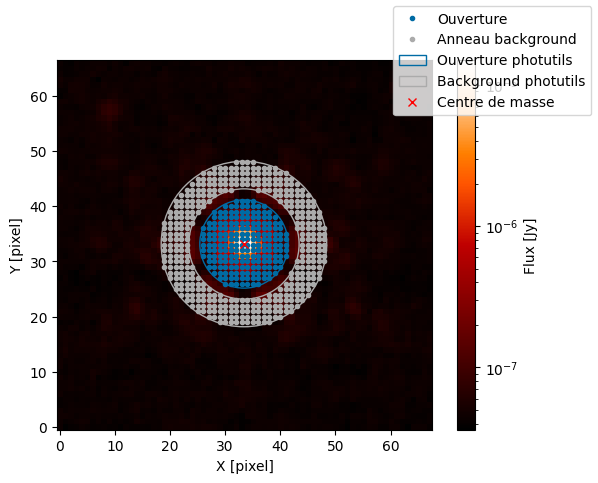

In [30]:
fig, ax = plot_image(data)
ax.plot(src_aperture["x"], src_aperture["y"], "C0.", label="Ouverture")
ax.plot(bkg_aperture["x"], bkg_aperture["y"], "C2.", label="Anneau background")
src_photutils.plot(ax=ax, color="C0", label="Ouverture photutils")
bkg_photutils.plot(ax=ax, color="C2", label="Background photutils")
plt.plot(mean_x, mean_y, "rx", label="Centre de masse")
fig.legend()
plt.show()

### 3 et 5. Calculer le flux total et le bruit de fond

Nous avons maintenant tout ce qu'il faut pour calculer la photométrie.
Il suffit de faire la somme du flux et de soustraire le bruit de fond.

In [31]:
bkg_flux = bkg_aperture["flux"]
median_bkg = np.median(bkg_flux)
src_flux = src_aperture["flux"]
N_pix = len(src_flux)
bkg_tot = N_pix * median_bkg
src_tot = np.sum(src_flux)
src_phot = src_tot - bkg_tot
print("Median background flux", median_bkg)
print("Total background flux", bkg_tot)
print("Raw source flux", src_tot)
print("Corrected source flux", src_phot)

Median background flux 5.3943467e-08
Total background flux 1.0842637e-05
Raw source flux 0.0002034747
Corrected source flux 0.00019263207


On peut vérifier les résultats avec photutils.
On utilise la méthode `center` qui approxime au pixel près, comme nous faisons plus haut.

In [32]:
from photutils.aperture import ApertureStats, aperture_photometry

# NOTE: Petite différence pour exact vs "center"
bkg_stats = ApertureStats(data, bkg_photutils)
src_stats = ApertureStats(data, src_photutils, sum_method="center")
photutils_aphot = aperture_photometry(data - bkg_stats.median, src_photutils, method="center")
print("Median background flux", bkg_stats.median)
print("Raw source flux", src_stats.sum)
print("Aperture photometry")
print(photutils_aphot)

Median background flux 5.394346835885244e-08
Raw source flux 0.00020347469104464722
Aperture photometry
 id      xcenter            ycenter           aperture_sum     
--- ------------------ ----------------- ----------------------
  1 33.407100773636515 33.16618282818617 0.00019263205390451787


### 6. Conversion du flux en magnitude

Nous avons maintenant le flux total en Jy.
Typiquement, la luminosité des objets astronomique est mesurée avec des [magnitudes](https://en.wikipedia.org/wiki/Magnitude_(astronomy)).

La façon la plus rapide d'obtenir des magnitudes est de convertir d'abord en magnitudes AB, puis en magnitude Vega en utilisant un fichier de référence fourni par l'équipe Webb.
Les équations ci-dessous sont tirées de la [documentation pour la calibration en flux NIRCam](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints#gsc.tab=0).

In [33]:
import asdf

ab_mag = -2.5 * np.log10(src_phot) + 8.9

def get_abvega_offset(filt: str):
    abvega_path = data_dir / "jwst_nircam_abvegaoffset_0002.asdf"
    with asdf.open(abvega_path) as af:
        offset_tbl = af["abvega_offset"]
    mask = (offset_tbl["filter"] == filt.upper()) & (offset_tbl["pupil"] == "CLEAR")
    offset_row = offset_tbl[mask]
    assert len(offset_row) == 1
    offset_row = offset_row[0]
    return offset_row["abvega_offset"]

ab_vega_offset = get_abvega_offset("f480m")
vega_mag = ab_mag - ab_vega_offset
print("Magnitude Vega", vega_mag)

Magnitude Vega 14.754625


### 7. Correction d'ouverture

Si vous comparez la magnitude ci-dessus avec celle de l'[article](https://ui.adsabs.harvard.edu/abs/2025AJ....169..163A/abstract) pour le même objet, vous remarquerez une petite différence.
Il faut en réalité corriger la magnitude pour tenir compte du fait que nous utilisons une ouverture finie, et qu'une partie de la luminosité n'est donc pas inclue dans l'ouverture.

La correction dépend du rayon de l'ouverture et de l'anneau de bruit de fond.
Il faut donc répéter le calcul de la photométrie avec les paramètres `r_phot`, `skyin` et `skyout`.
Ensuite, il faudra multiplier le flux total par `apcorr`.
Utilisons `photutils` pour répéter l'analyse.


In [34]:
aperture_info_dict = {
    "f480m": dict(zip(("filt", "pupil", "ee", "r_phot", "apcorr", "skyin", "skyout"), ('F480M', 'CLEAR', 0.7 ,  3.757,  1.4863, 4.92 , 7.083))),
    "f150w": dict(zip(("filt", "pupil", "ee", "r_phot", "apcorr", "skyin", "skyout"), ('F150W', 'CLEAR', 0.7 ,  3.199,  1.4485, 6.082, 9.496))),
}
aperture_info = aperture_info_dict["f480m"]

src_photutils = CircularAperture(xy_com, r=aperture_info["r_phot"])
bkg_photutils = CircularAnnulus(xy_com , r_in=aperture_info["skyin"], r_out=aperture_info["skyout"])

bkg_stats = ApertureStats(data, bkg_photutils)
src_stats = ApertureStats(data, src_photutils, sum_method="center")
photutils_aphot = aperture_photometry(data - bkg_stats.median, src_photutils)
src_phot = photutils_aphot["aperture_sum"] * aperture_info["apcorr"]

ab_mag = -2.5 * np.log10(src_phot) + 8.9
vega_mag = ab_mag - ab_vega_offset
print("Magnitude Vega:", vega_mag.data.item())

Magnitude Vega: 14.540362713145996


La magnitude est maintenant similaire à celle rapportée dans l'article!

## Conclusions

Voilà! Nous avons traversé toutes les étapes du calcul de la photométrie d'ouverture.
Avec ce code, vous devriez pouvoir refaire le calcul pour le filtre F150W ou même pour une autre cible.

Suggestions d'exercices additionnels, si vous voulez explorer le sujet un peu plus:

- Adaptez le code pour calculer la photométrie du filtre F150W également
- Nous n'avons pas calculé d'incertitudes! Les opérations effectuées ci-dessus respectent les mêmes règles de propagation d'erreur que vous avez vues lors de vos laboratoire. Pouvez-vous propager l'incertitude de l'image (donnée par l'extension `ERR`) au flux total? Puis à la magnitude? L'exemple du lien ci-dessous montre un exemple de calcule tenant compte des incertitudes.
- Explorez cet exemple de l'équipe JWST montrant comment calculer photométrie d'ouverture pour plusieurs étoiles dans la même image: <https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRCam/aperture_photometry/NIRCam_Aperture_Photometry_Example.html#point-source-aperture-photometry>
- Explorez cet exemple de photométrie sur des images de galaxies: <https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRCam/NIRCam_photometry/NIRCam_multiband_photometry.html>. La photométrie se calcule un peu différemment pour les sources étendues.